# **Home Assignment 2**
**Objective:** Implement and analyze different generative models for image generation and translation.  

## **General Instructions**  
✅ **Code Implementation:**  
- Write code in the specified notebook cells.  
- Use **built-in methods** from libraries (e.g., `sklearn`, `PyTorch`) instead of reinventing the wheel.  
- Ensure reproducibility by fixing random seeds (e.g., `random_state=42`).  

📝 **Discussion & Reporting:**  
- Add a **Markdown cell** after each task to discuss results (if required).  
- Keep explanations concise.  

⚠ **Grading Policy**  
- **All-or-nothing scoring** – Full points or zero for each subtask (no partial credit).  
- **Mandatory reproducibility** – Reviewers must obtain identical results when rerunning your notebook.  
- **Output preservation required** – TAs will not rerun notebooks unless potential fraud is detected.  

🔍 **Allowed Resources:**  
- Official docs: [Python](https://docs.python.org/3/), [NumPy](https://numpy.org/doc/), [Matplotlib](https://matplotlib.org/), [scikit-learn](https://scikit-learn.org/stable/).  
- External help: Lecture slides, seminars, Google, StackOverflow.  

---

### **Final Checklist**  
✔ All code is **well-commented** and reproducible.  
✔ Discussions are included where required.  
✔ Notebook runs **end-to-end without errors**.  

**Tip:** Use section headers (like above) in your notebook to improve readability.  

---

# **Part 1: Energy-Based Models via Diffusion Recovery Likelihood (16 points)**  

Imports:

In [ ]:
!pip install --no-deps ema-pytorch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.distributions as TD
from torch.utils.data import DataLoader
import os, sys
from tqdm import tqdm
import torch.optim as optim
from collections import defaultdict

# ema (exponential moving average) is the technique to average
# weights of NN (for stability at inferense stage).
from ema_pytorch import EMA

if torch.cuda.is_available():
    DEVICE = "cuda"
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE = "cpu"
# DEVICE='cpu'
print("Used device:", DEVICE)

import warnings

warnings.filterwarnings("ignore")

## 1. Task Overview

In this problem, you are asked to implement a specific Energy-Based Model (EBM) and train it on a 2D distribution.

---

From **Seminar 6**, you know that EBMs specify data distribution through an energy function $E_{\theta}(x)$:

$$
p_{\theta}(x) = \frac{1}{Z} \exp(- E_{\theta}(x)) \approx p_{\text{data}}(x).
$$

To learn EBMs, we use Maximum Likelihood Estimation (MLE) (minimizing the forward KL divergence between $p_{\text{data}} \equiv p^*$ and $p_{\theta}$):

$$
\mathbb{E}_{x \sim p^*} \log p_{\theta}(x) \rightarrow \max_{\theta}
$$

with a "proxy" **loss**:

$$
L(\theta) = \mathbb{E}_{x \sim p^*} E_{\theta}(x) - \mathbb{E}_{x \sim p_{\theta}} E_{\theta}(\text{stop\_grad }[x]) \rightarrow \min_{\theta}
$$

To **sample** from $p_{\theta}$ during both training and inference, we use *Langevin dynamics:

1. Sample $x_{0} \sim p_{x_0}$ (from some simple distribution)

2. Fix $\tau > 0$ and for $k \in \{0, 1, \dots K\}$ do:

$$x_{(k + 1) \tau} = x_{k \tau} - \tau \frac{1}{2} \nabla_{x} E_{\theta}(x_{k \tau}) + \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

#### Problems:

- $E_{\theta}$ may define highly multimodal distributions $\Rightarrow$ sampling from $p_{\theta}$ may require too much time to mix (converge)

- If replay buffers or data initializations (i.e., $p_{x_0}$ is a data-dependent distribution) are used during training, the learned EBM may not know how to transform pure noise into data (since it only sees good data during training).

### Solution:

Proposed in the DRL paper [Gao et al., 2021](https://openreview.net/pdf?id=v_1Soh8QUNc) and follow-up CDRL paper [Zhu et al., 2024](https://openreview.net/pdf?id=AyzkDpuqcl).

**Data noising process**:

$$x_0 \sim p_{\text{data}} \, , \quad x_{t + 1} = a_{t+1} x_t + \sigma_{t + 1} \epsilon_{t + 1}\, ; \quad (\#)\\ \epsilon_{t + 1} \sim \mathcal{N}(0, I) \, , \\ \, t = 0, 1, \dots , T - 1.$$

*Note*: $0 < a_{t}, \sigma_{t} \leq 1$ are chosen to interpolate between the data distribution and noise distribution.

* Typically, $\sigma_{t} = \sqrt{1 - a_{t}^2}$ (VP - *variance preserving* noise schedule). In this case, $x_{t} = \overline{a}_t x_0 + \overline{\sigma}_t \epsilon$, where $\overline{a}_t = \prod_{\tau = 1}^{t} a_{\tau}$; $\overline{\sigma}_t = \sqrt{1 - \overline{a}_t^2}$;

* We expect (approximately) $x_T \sim \mathcal{N}(0, I)$.

**Key theorem (recovery likelihood)**:

Consider the *noising process* $(\#)$. Let the marginal density of samples $x_t$ be $p(x_t) = \frac{1}{Z_t} \exp( f(x_t, t))$. Let $y_t = a_{t+1} x_t$. Then,

$$ p(y_t | x_{t + 1}) = \frac{1}{\tilde{Z}_t(x_{t + 1})} \exp \Big( f(y_t, t) - \frac{1}{2 \sigma_{t + 1}^2} \Vert x_{t + 1} - y_t \Vert_2^2 \Big).$$

*Nice properties*:

* The conditional distribution $p(y_t | x_{t + 1})$ is almost unimodal (especially if $\sigma_{t + 1}$ is small) $\Rightarrow$ Langevin sampling is expected to work well;

* Given $x_{T} \sim \mathcal{N}(0, I)$, we may subsequently sample from $p(y_t | x_{t + 1})$ to transform pure noise into data.

#### Objective

Introduce a time-dependent scalar-valued Neural Network $f_{\theta}(x, t)$, which defines the (negative) energy of data at different noise levels. 

**Loss function**: 

$$\sum_{t = 1}^{T - 1} \mathbb{E}_{x_{t + 1} \sim p(x_{t + 1})} KL\big(p(y_t | x_{t + 1}) \Vert p_{\theta} (y_t | x_{t + 1})\big) \rightarrow \min_{\theta}.$$

*Simplification* (derive by yourself!):

$$\mathbb{E}_{x_{t + 1} \sim p(x_{t + 1})} KL\big(p(y_t | x_{t + 1}) \Vert p_{\theta} (y_t | x_{t + 1})\big) = \\
\text{Const}(\theta) - \mathbb{E}_{y_t \sim p(y_t)} \Big[ \mathbb{E}_{x_{t + 1} \sim p(x_{t + 1} | y_t)} \log \big( p_{\theta} (y_t | x_{t + 1}) \big)\Big].
$$

**Final objective** (summued up for $t \in 1, 2, \dots T-1$):

$$
\mathbb{E}_{y_t \sim p(y_t)} \Big[ \mathbb{E}_{x_{t + 1} \sim p(x_{t + 1} | y_t)} \log \big( p_{\theta} (y_t | x_{t + 1}) \big)\Big] \rightarrow \max_{\theta}.
$$

Proxy **loss** (similar to standard EBMs) (derive by yourself, similar to Lecture/Seminar on EBMs!):

$$
\mathbb{E}_{y_t \sim p(y_t)} \big( \mathbb{E}_{x_{t + 1} \sim p(x_{t + 1} | y_t)} \mathbb{E}_{\tilde{y}_t \sim p_{\theta}(y_t | x_{t + 1})} f_{\theta} (\text{stop\_grad}[\tilde{y}_t], t) - f_{\theta} ( y_t, t) \big) \rightarrow \min_{\theta}
$$

**Algorithm** (Equation 17 below is sampling from $p_{\theta} (y_t | x_{t + 1})$ with Langevin):

<center>
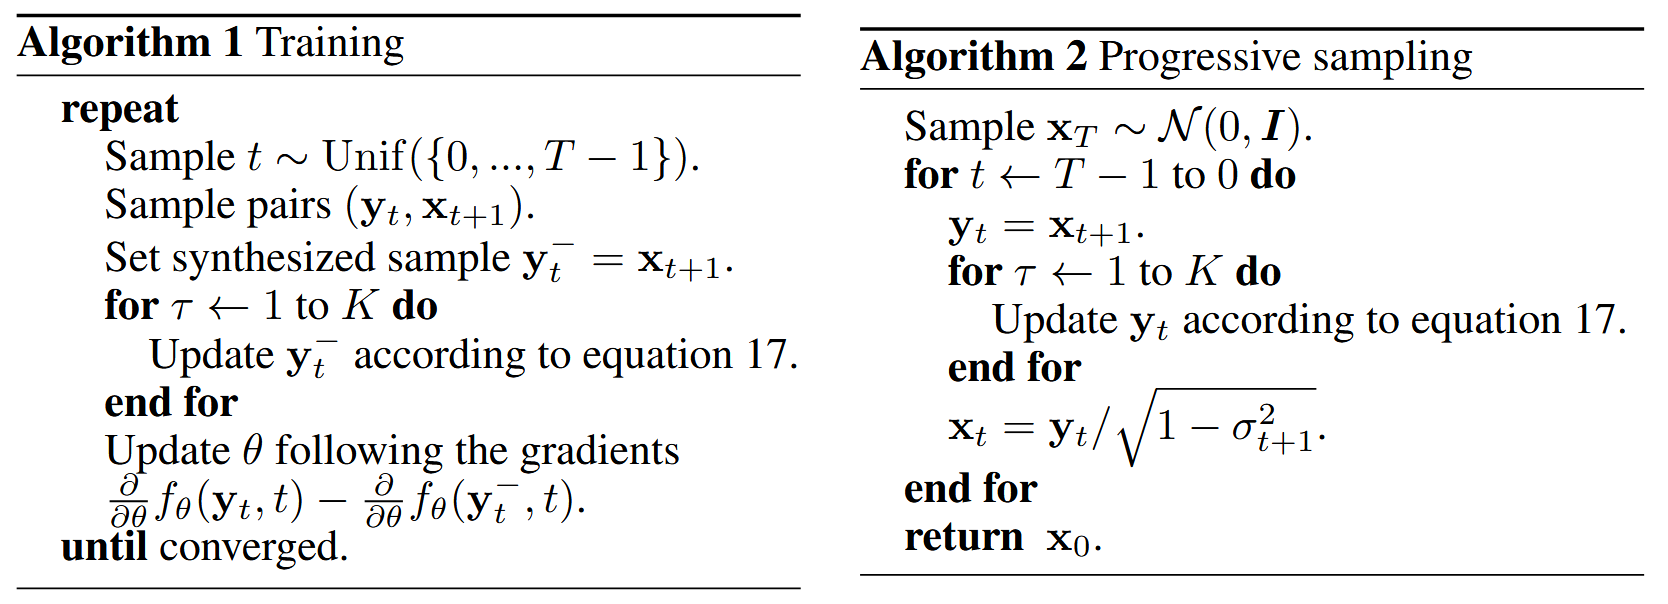
</center>

## 2. Generative problem

`2D` distribution to fit our generative model

Utils

In [ ]:
def visualize_2d_samples(data, title, c=None, xlabel=None, ylabel=None, label=None, s=4, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(data[:, 0], data[:, 1], s=s, c=c, label=label)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if label is not None:
        ax.legend(fontsize=12)
    return ax

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split


def make_swiss_roll_2D(n_samples, noise=0.5, factor=7.5):
    x, _ = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=42)
    x /= factor
    return np.concatenate([x[:, 0][:, None], x[:, 2][:, None]], axis=1)

Train & test data

In [ ]:
COUNT = 10000

train_data, test_data = train_test_split(make_swiss_roll_2D(COUNT), test_size=0.2, random_state=42)
train_data = torch.FloatTensor(train_data).to(DEVICE)
test_data = torch.FloatTensor(test_data).to(DEVICE)

fig, ax = plt.subplots(figsize=(5, 5))
visualize_2d_samples(train_data.cpu(), "train&test", ax=ax, label="train", c="b")
visualize_2d_samples(test_data.cpu(), "train&test", ax=ax, label="test", c="r")
plt.show()

## 3. Implementation details

### 3.1 Model (3 points)

**Tasks**:

1. Implement time-conditional `MLP` which parameterizes $f_{\theta}(x, t)$. To embed time into the model, you may use simple concatenation, or more sophisticated [positional encoding](https://discuss.pytorch.org/t/how-to-modify-the-positional-encoding-in-torch-nn-transformer/104308/3).

2. Implement function `ebm_grad` which calculates gradient of ebm model (cf. Seminar 6)

In [ ]:
class EBMt(nn.Module):

    def __init__(self, input_dim, hiddens, activation_gen=lambda: nn.ReLU()):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = 1
        self.hiddens = hiddens

        ### YOUR CODE HERE
        # ...
        self.net = nn.Sequential(*model)
        ###

    def forward(self, x, t):
        ### YOUR CODE HERE
        # ...
        return self.net(...).view(batch_size, self.output_dim)
        ###


def ebm_grad(ebm, x, t):
    x = x.detach()
    with torch.enable_grad():
        # YOUR CODE HERE
        # ...
        return grad
        ###

### 3.2 Noise Schedule (3 points)

*Note*: You may implement a noise schedule on your own. Below we provide one particular approach used in the authors' implementation:

**Noise schedule from [DDPM](https://arxiv.org/abs/2006.11239) model**:

*Note*: In the original DDPM paper, the authors use slightly different notation for the noising process: $x_{t + 1} = \sqrt{\alpha_{t + 1}} x_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1}$ where $\alpha_{t + 1} = 1 - \beta_{t + 1}$. The conversion from our notation to DDPM notation is: $\sigma_{t + 1} = \sqrt{\beta_{t + 1}}$, $a_{t + 1} = \sqrt{\alpha_{t + 1}}$.

* In the DDPM paper, the authors use $T = 1000$ and interpolate linearly from $\tilde{\sigma}_1^2 = 10^{-4}$ to $\tilde{\sigma}_T^2 = 0.02$.

* We want a much smaller $T$ (e.g., $T \approx 10$), but with the same (though coarser) noise schedule:

    * Transform $\tilde{\sigma}_t \rightarrow \tilde{a}_t$;
    
    * Set $a_0 = \tilde{a}_1$ for notational simplicity when $t = 0$. In particular, our model $f_{\theta}(y, t = 0)$ will learn a slightly noised version of the data distribution: $a_0 p_{\text{data}} + \sqrt{1 - a_0^2} \mathcal{N}(0, I)$.
    
    * Compute the "coarser" weights: $a_1 = \prod_{t = 2}^{t_1} \tilde{a}_t$, $a_2 = \prod_{t = t_1}^{t_2} \tilde{a}_t$, $\dots$, where the time splits $t_1, t_2, \dots, t_{T}$ are chosen equidistantly on $[2, 1000]$;
    
    * Compute all remaining quantities from $a_t$ accordingly.


**Task**: Implement the noise schedule for the data noising process.

The function `get_noise_schedule` should return:

* Lists of $a_t$ and $\sigma_t$ for $t = 0, 1, 2, \dots, T$;

* Lists of $\overline{a}_t$ and $\overline{\sigma}_t$ to directly sample $x_t$ given $x \sim p_{\text{data}}$;

* A list of log signal-to-noise ratios (SNRs) $\lambda_t = \log \frac{\overline{a}_t^2}{\overline{\sigma}_t^2}$. It is worth using $\lambda_t$ as the condition for $f_{\theta}(x, \lambda_t)$ rather than directly using time $t$.

In [ ]:
def get_noise_schedule(*, sigmasq_start=1e-4, sigmasq_end=2e-3, num_diffusion_timesteps=6, device=DEVICE):
    ### YOUR CODE HERE
    # ...
    a_s = np.asarray([np.prod(a_tilde[ts[i - 1]:ts[i]]) for i in range(1, num_diffusion_timesteps + 2)])
    sigmas = # YOUR CODE HERE
    cum_a_s = # YOUR CODE HERE
    cum_sigmas = # YOUR CODE HERE
    lsnrs = # YOUR CODE HERE
    return dict(
        lsnrs = torch.FloatTensor(lsnrs).to(device),
        a_s = torch.FloatTensor(a_s).to(device),
        sigmas = torch.FloatTensor(sigmas).to(device),
        cum_a_s = torch.FloatTensor(cum_a_s).to(device), 
        cum_sigmas = torch.FloatTensor(cum_sigmas).to(device),
    )
    ###

In [ ]:
NUM_NOISE_LEVELS = 4
schedules = get_noise_schedule(num_diffusion_timesteps=NUM_NOISE_LEVELS)
sigmas = schedules["sigmas"]
a_s = schedules["a_s"]
cum_a_s = schedules["cum_a_s"]
cum_sigmas = schedules["cum_sigmas"]
lsnrs = schedules["lsnrs"]

In [ ]:
print(sigmas)

In [ ]:
print(a_s)

In [ ]:
print(cum_a_s)

In [ ]:
print(cum_sigmas)

In [ ]:
print(lsnrs)

### 3.3 Langevin sampling (6 points)

**Task.** Implement Langevin sampling from conditional distribution $p_{\theta}(y_t | x_{t + 1}) = \frac{1}{\tilde{Z}_t(x_{t + 1})} \exp \Big( f_{\theta}(y_t, \lambda_t) - \frac{1}{2 \sigma_{t + 1}^2} \Vert x_{t + 1} - y_t \Vert_2^2 \Big)$.

$$
y_{t}^{\tau + 1} = y_t^{\tau} + \frac{\delta_t^2}{2} \big( \nabla_y f_{\theta} (y_t^\tau, \lambda_t) + \frac{1}{\sigma_{t + 1}^2} (x_{t + 1} - y_t^{\tau})\big) + \delta_t \epsilon_{\tau},
$$

$\delta_t$ is the step size.

**Hint**: it is reasonable to choose $\delta_t = B \sigma_{t + 1}$, where $B < 1$ is a hyperparameter to tune.

**Note**: Choose scaling of your energy function, e.g., your Neural Network $\tilde{f}$ may actually define $\tilde{f}_{\theta} = f_{\theta} \cdot \sigma_{t + 1}^2$

In [ ]:
def sample_langevin(
    t: int,  # timestamp
    ebm: nn.Module,  # ebm model
    y_0: torch.Tensor,  # initial sample
    xt1: torch.Tensor,  # condition
    l_mcmc: int = 30,  # number of langevin steps
    B: float = 0.1,  # see Hint above
):
    """Samples from p(y | x_{t + 1}) with langevin"""
    bs = y_0.size(0)
    lsnr = lsnrs[t].repeat(bs)
    y = y_0.clone()
    ### YOUR CODE HERE
    # ...
    return y.detach()
    ###

**Task.** Implement Progressive sampling (Algorithm 2):

* Use $\mathcal{N}(0, I_2)$ (`2D` distribution) as the initial distribution;

* Take the advantage of `sample_langevin` function.

* Keep trace of the generated samples at different noise levels

In [ ]:
# Sampling function
def generate_samples(
    ebm : nn.Module,
    l_mcmc : int = 30, # number of langevin steps
    B : float = 0.1, # see Hint above
    num_samples=1024, 
    device=DEVICE):
    '''Generate samples from the trained EBM'''
    
    y = torch.randn(num_samples, 2).to(device)
    trace = [y.clone().cpu(),]
    ### YOUR CODE HERE
    for t in torch.arange(NUM_NOISE_LEVELS - 1, -1, -1):
        # ....
        y = #...
        trace.append(y.clone().cpu())
    ###
        
    return y.detach(), trace

### 3.4 Training procedure (4 points)

Utils

In [ ]:
def plot_ebm_losses(losses, epoch, last_n_epochs=None):
    epoch = epoch + 1
    if last_n_epochs == None:
        last_n_epochs = epoch
    plt.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    plt.axhline(y=0.5, color="black", linestyle=":", linewidth=0.5)
    plt.axhline(y=-0.5, color="black", linestyle=":", linewidth=0.5)
    frac = min(last_n_epochs / epoch, 1.0)
    for k, v in losses.items():
        v = v[int((1.0 - frac) * len(v)) : len(v)]
        xs = np.linspace(epoch - min(last_n_epochs, epoch), epoch, len(v))
        plt.plot(xs, v, label=k, alpha=0.5)
    plt.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    plt.xlabel("epochs")
    plt.legend(ncols=3)
    plt.title("losses")
    plt.show()

Hyperparameters:

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS = 1000
LR = 1e-4
L_MCMC = 30
B = 0.1

**Task.** Implement Training (Alogorithm 1):

* Use `EMA` to sample at inference stage

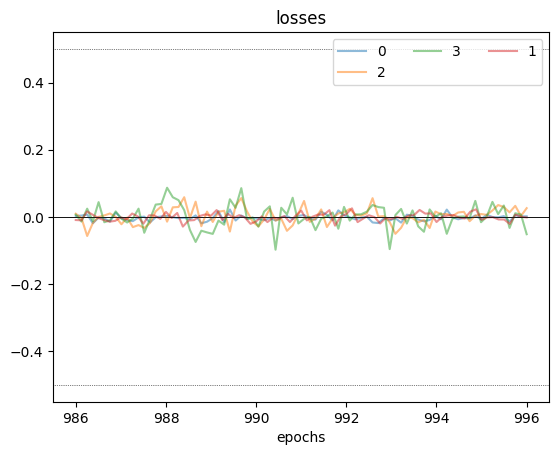

In [194]:
### YOUR CODE HERE
train_loader =  DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

ebm = # your model
optimizer = # your optimizer, Adam is recommended
losses = defaultdict(list)
ema = EMA(ebm, beta=0.99, update_after_step=1000, update_every=10)

ebm.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, x0 in enumerate(train_loader):
        x0 = x0.to(DEVICE)
        
        t = # Select a random noise level (one timestep per batch)
        xt = # get x_t
        yt = # get y_t
        xt1 = # get x_{t + 1}
        yt_neg = # init for langevin (use xt1)
        lsnr = # current lsnr level

        # langevin dynamics
        yt_neg = # perform langevin sampling
        
        
        # Compute loss (negative recovery likelihood)
        energy_yt = # ...
        energy_yt_neg = # ...
        
        loss = # ...
        losses[t.item()].append(loss.item())
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update()
        
    if epoch % 5 == 0:
        clear_output(True)
        plot_ebm_losses(losses, epoch, last_n_epochs=10)
    
    if epoch % 10 == 0:
        x_gen, _ = generate_samples(ema, L_MCMC, B, num_samples=2048)
        fig, ax = plt.subplots(figsize=(5, 5))
        visualize_2d_samples(test_data.cpu(), 'generated', ax=ax, label='test', c='r')
        visualize_2d_samples(x_gen.cpu(), 'generated', ax=ax, label='gen', c='g')
        ax.set_xlim(-2.2, 2.2)
        ax.set_ylim(-2.2, 2.2)
        plt.show()
###

Obtain final samples:

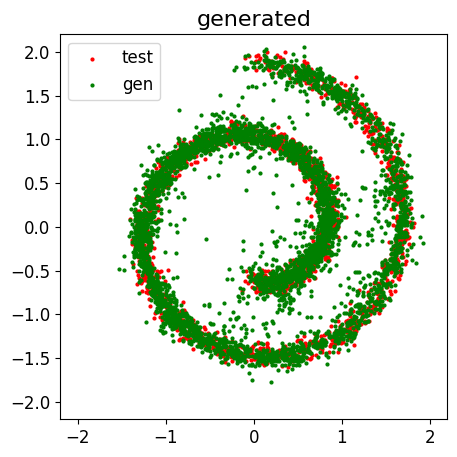

In [ ]:
x_gen, _ = generate_samples(ema, L_MCMC, B, num_samples=4096)
fig, ax = plt.subplots(figsize=(5, 5))
visualize_2d_samples(test_data.cpu(), "generated", ax=ax, label="test", c="r")
visualize_2d_samples(x_gen.cpu(), "generated", ax=ax, label="gen", c="g")
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
plt.show()

**Observation 1**. Take a look at the learned score function at different *noise* levels

Utils:

In [ ]:
def get_score_t(ebmt, t):
    def _score(x):
        t_lsnr = lsnrs[t : t + 1].repeat(x.size(0)).to(x)
        return ebm_grad(ebm, x, t_lsnr)

    return _score


def plot_score_function(
    score_function,
    title,
    xlim=(-2.0, 2.0),
    ylim=(-2.0, 2.0),
    ngrid=40,
    quiver_color="black",
    device=DEVICE,
):
    xx = np.stack(
        np.meshgrid(np.linspace(xlim[0], xlim[1], ngrid), np.linspace(ylim[0], ylim[1], ngrid)), axis=-1
    ).reshape(-1, 2)

    scores = score_function(torch.tensor(xx).float().to(device)).detach().cpu().numpy()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_adj = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.quiver(*xx.T, *scores_adj.T, width=0.002, color=quiver_color)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title, fontsize=16)
    return ax

In [ ]:
t = 0
plot_score_function(get_score_t(ema, t), f"score, t={t}", plot_scatter=False)
plt.show()

**Observation 2.** Take a look at the obtained samples at different *noise* levels.

In [ ]:
_, trace = generate_samples(ema, L_MCMC, B)

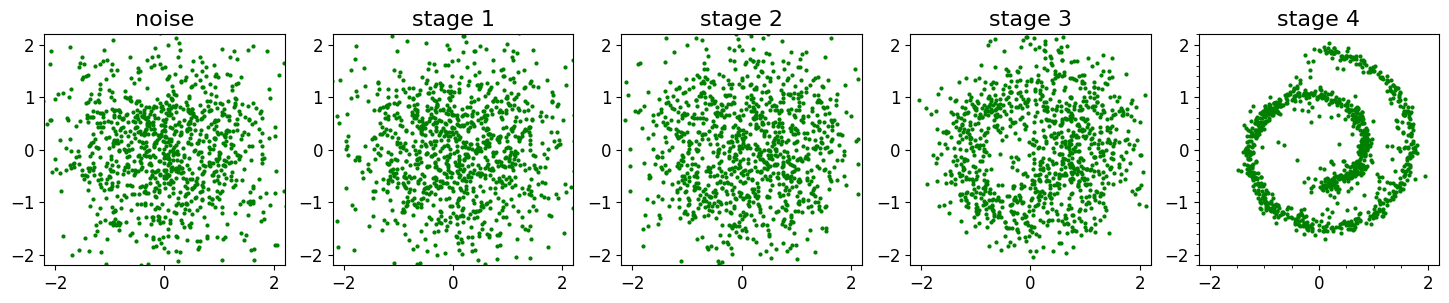

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(18, 3))
for t, ax in enumerate(axs.reshape(-1)):
    if t < len(trace):
        if t == 0:
            title = "noise"
        else:
            title = f"stage {t}"
        visualize_2d_samples(trace[t], title, ax=ax, c="g")
        ax.set_xlim(-2.2, 2.2)
        ax.set_ylim(-2.2, 2.2)
plt.minorticks_on()
plt.show()

**Conclusions**